In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.transforms import NormalizeScale
from torch_geometric.nn import knn_graph
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Function to load .off files
def load_off(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        if lines[0].strip() == 'OFF':
            lines = lines[1:]
        n_verts, n_faces, _ = map(int, lines[0].strip().split())
        vertices = np.array([list(map(float, lines[i + 1].strip().split())) for i in range(n_verts)])
        return vertices

# Custom dataset class for ModelNet10
class ModelNet10GraphDataset(InMemoryDataset):
    def __init__(self, root, split='train', transform=None, pre_transform=None):
        self.split = split
        self.class_to_idx = self.get_class_to_idx(root)
        super(ModelNet10GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'{self.split}_data.pt']

    def process(self):
        data_list = []
        #root_dir = self.raw_dir

        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for split in ['train', 'test']:
                    split_dir = os.path.join(cls_dir, split)
                    if os.path.isdir(split_dir):
                        for file_name in os.listdir(split_dir):
                            if file_name.endswith('.off'):
                                file_path = os.path.join(split_dir, file_name)
                                point_cloud = load_off(file_path)
                                if len(point_cloud) > 1024:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=False)]
                                else:
                                    point_cloud = point_cloud[np.random.choice(len(point_cloud), 1024, replace=True)]
                                pos = torch.tensor(point_cloud, dtype=torch.float)
                                y = torch.tensor([self.class_to_idx[cls]], dtype=torch.long)
                                edge_index = knn_graph(pos, k=16)
                                data = Data(pos=pos, edge_index=edge_index, y=y)
                                data_list.append(data)
        
        if not data_list:
            raise RuntimeError("No data found. Please check your dataset directory and file structure.")
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def download(self):
        pass

    def get_class_to_idx(self, root_dir):
        classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return class_to_idx

# Ensure the dataset structure is correct
def verify_dataset_structure(root_dir):
    classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            train_dir = os.path.join(cls_dir, 'train')
            test_dir = os.path.join(cls_dir, 'test')
            if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
                raise RuntimeError(f"Expected 'train' and 'test' directories in {cls_dir}")
            print(f"Found class: {cls} with 'train' and 'test' subdirectories.")
        else:
            raise RuntimeError(f"Expected directory for class {cls} in {root_dir}")


In [3]:
# Define data paths
root_dir = 'C:/Users/Owner/Downloads/ModelNet10/ModelNet10'
verify_dataset_structure(root_dir)

train_dataset = ModelNet10GraphDataset(root=root_dir, split='train', pre_transform=NormalizeScale())
test_dataset = ModelNet10GraphDataset(root=root_dir, split='test', pre_transform=NormalizeScale())


Found class: bathtub with 'train' and 'test' subdirectories.
Found class: bed with 'train' and 'test' subdirectories.
Found class: chair with 'train' and 'test' subdirectories.
Found class: desk with 'train' and 'test' subdirectories.
Found class: dresser with 'train' and 'test' subdirectories.
Found class: monitor with 'train' and 'test' subdirectories.
Found class: night_stand with 'train' and 'test' subdirectories.
Found class: sofa with 'train' and 'test' subdirectories.
Found class: table with 'train' and 'test' subdirectories.
Found class: toilet with 'train' and 'test' subdirectories.


In [4]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# GNN model definition
class GCN(nn.Module):
    def __init__(self, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.pos, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# Define model, loss function, and optimizer
num_classes = len(train_dataset.class_to_idx)
model = GCN(num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar and data tracking
num_epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for data in train_bar:
        data = data.to('cuda')

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        
        train_bar.set_postfix(loss=running_loss / (total / 32), accuracy=100. * correct / total)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)
    
    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to('cuda')
            outputs = model(data)
            loss = criterion(outputs, data.y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100. * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {100. * correct / total:.2f}%")
    print(f"train_losses: {train_losses}, test_losses: {test_losses}")
    print(f"train_accuracies: {train_accuracies}, test_accuracies: {test_accuracies}")

print('Finished Training')

Epoch 1/50: 100%|███████████████████████████████████████| 154/154 [00:16<00:00,  9.16batch/s, accuracy=27.9, loss=3.74]


Epoch 1, Test Loss: 2.1697, Test Accuracy: 42.80%
train_losses: [3.717384146405505], test_losses: [2.1696523366036353]
train_accuracies: [27.86282914880588], test_accuracies: [42.804654011022656]


Epoch 2/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.42batch/s, accuracy=37.8, loss=3.41]


Epoch 2, Test Loss: 3.1552, Test Accuracy: 40.80%
train_losses: [3.717384146405505, 3.391279551115903], test_losses: [2.1696523366036353, 3.155164374159528]
train_accuracies: [27.86282914880588, 37.762808736476835], test_accuracies: [42.804654011022656, 40.804245764441724]


Epoch 3/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.74batch/s, accuracy=42.2, loss=2.19]


Epoch 3, Test Loss: 1.8418, Test Accuracy: 47.34%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988]


Epoch 4/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.51batch/s, accuracy=46.5, loss=1.75]


Epoch 4, Test Loss: 1.5076, Test Accuracy: 51.40%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198]


Epoch 5/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.49batch/s, accuracy=54.6, loss=1.51]


Epoch 5, Test Loss: 1.5115, Test Accuracy: 53.21%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215]


Epoch 6/50: 100%|████████████████████████████████████████████| 154/154 [00:14<00:00, 10.80batch/s, accuracy=52, loss=2]


Epoch 6, Test Loss: 1.6282, Test Accuracy: 56.38%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757]


Epoch 7/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.33batch/s, accuracy=58.9, loss=1.65]


Epoch 7, Test Loss: 1.5503, Test Accuracy: 56.58%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015]


Epoch 8/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.42batch/s, accuracy=63.7, loss=1.32]


Epoch 8, Test Loss: 1.1444, Test Accuracy: 66.73%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015, 66.7279036538069]


Epoch 9/50: 100%|███████████████████████████████████████| 154/154 [00:14<00:00, 10.48batch/s, accuracy=67.9, loss=1.09]


Epoch 9, Test Loss: 0.9615, Test Accuracy: 71.40%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015, 66.7279036538069, 71.40232700551132]


Epoch 10/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.65batch/s, accuracy=71.1, loss=0.971]


Epoch 10, Test Loss: 1.2884, Test Accuracy: 70.14%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015, 66.7279036538069, 71.40232700551132, 70.13676260461318]


Epoch 11/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.62batch/s, accuracy=71.6, loss=0.926]


Epoch 11, Test Loss: 0.8689, Test Accuracy: 72.61%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015, 66.7279036538069, 71.40232700551132, 70.13676260461318, 72.60665441926923]


Epoch 12/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.37batch/s, accuracy=72.8, loss=0.848]


Epoch 12, Test Loss: 0.8152, Test Accuracy: 74.83%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582976117575015, 66.7279036538069, 71.40232700551132, 70.136

Epoch 13/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.35batch/s, accuracy=73.5, loss=0.865]


Epoch 13, Test Loss: 0.7812, Test Accuracy: 75.02%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432, 73.50479689732599], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39824453970198, 53.214941824862215, 56.37885282710757, 56.582

Epoch 14/50: 100%|██████████████████████████████████████| 154/154 [00:15<00:00,  9.66batch/s, accuracy=67.1, loss=1.23]


Epoch 14, Test Loss: 1.2098, Test Accuracy: 67.20%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432, 73.50479689732599, 67.09532557664829], test_accuracies: [42.804654011022656, 40.804245764441724, 47.33619105939988, 51.39

Epoch 15/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.54batch/s, accuracy=71.8, loss=0.98]


Epoch 15, Test Loss: 0.8381, Test Accuracy: 74.14%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432, 73.50479689732599, 67.09532557664829, 71.81057358644621], test_accuracies: [42.80

Epoch 16/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.57batch/s, accuracy=74.5, loss=0.823]


Epoch 16, Test Loss: 0.8082, Test Accuracy: 75.48%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432, 73.50479689732599, 67.09532557664829, 71.

Epoch 17/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=73.7, loss=0.935]


Epoch 17, Test Loss: 2.0574, Test Accuracy: 65.01%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365, 71.64727495407226, 72.7699530516432, 73

Epoch 18/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.51batch/s, accuracy=72.9, loss=0.886]


Epoch 18, Test Loss: 0.7507, Test Accuracy: 76.16%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.74770361298224, 67.93223106756481, 71.13696672790365,

Epoch 19/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=76.8, loss=0.731]


Epoch 19, Test Loss: 0.9834, Test Accuracy: 75.04%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110431, 58.90998162890386, 63.7477036129822

Epoch 20/50: 100%|███████████████████████████████████████| 154/154 [00:15<00:00,  9.92batch/s, accuracy=77, loss=0.712]


Epoch 20, Test Loss: 0.6368, Test Accuracy: 79.08%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.54011022657685, 54.64380485813431, 52.01061441110

Epoch 21/50: 100%|█████████████████████████████████████| 154/154 [00:14<00:00, 10.82batch/s, accuracy=78.6, loss=0.661]


Epoch 21, Test Loss: 0.6107, Test Accuracy: 79.98%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.6106947761077386]
train_accuracies: [27.86282914880588, 37.762808736476835, 42.23310879771382, 46.540110226

Epoch 22/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00,  9.92batch/s, accuracy=79.5, loss=0.624]


Epoch 22, Test Loss: 0.5973, Test Accuracy: 79.93%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.6106947761077386, 0.5973292470655658]
train_accuracies: [27.86282914880588, 37.76280873

Epoch 23/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.51batch/s, accuracy=80.5, loss=0.614]


Epoch 23, Test Loss: 0.5828, Test Accuracy: 80.47%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.6106947761077386, 0.5973292470655658, 0.5827875124750199]
train_acc

Epoch 24/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=80.9, loss=0.582]


Epoch 24, Test Loss: 0.5505, Test Accuracy: 81.67%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.6106947761077386, 0.5973292470655658, 0.5827875

Epoch 25/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=77.1, loss=0.989]


Epoch 25, Test Loss: 2.7303, Test Accuracy: 59.48%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.6106947761077386, 0.5973292

Epoch 26/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=49.8, loss=6.16]


Epoch 26, Test Loss: 1.4813, Test Accuracy: 67.01%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635401713, 0.610694776

Epoch 27/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.54batch/s, accuracy=69.7, loss=1.48]


Epoch 27, Test Loss: 3.9262, Test Accuracy: 56.34%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446367654, 0.6367546635

Epoch 28/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.58batch/s, accuracy=72.5, loss=1.15]


Epoch 28, Test Loss: 0.9892, Test Accuracy: 74.34%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638138353, 0.9834378446

Epoch 29/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.51batch/s, accuracy=76.1, loss=0.944]


Epoch 29, Test Loss: 1.0109, Test Accuracy: 69.46%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683760937, 0.7506608638

Epoch 30/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=74.5, loss=0.857]


Epoch 30, Test Loss: 0.7254, Test Accuracy: 76.63%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.8081713935432883, 2.057435683

Epoch 31/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.56batch/s, accuracy=77.4, loss=0.734]


Epoch 31, Test Loss: 0.6673, Test Accuracy: 78.49%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.8380977775079089, 0.808171393

Epoch 32/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.45batch/s, accuracy=78.4, loss=0.65]


Epoch 32, Test Loss: 0.6319, Test Accuracy: 79.00%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.2098080207194601, 0.838097777

Epoch 33/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.53batch/s, accuracy=79.7, loss=0.626]


Epoch 33, Test Loss: 0.5927, Test Accuracy: 80.14%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.781224692312928, 1.209808020

Epoch 34/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.54batch/s, accuracy=80.4, loss=0.601]


Epoch 34, Test Loss: 0.5821, Test Accuracy: 80.40%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.8151660707670373, 0.78122469

Epoch 35/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.52batch/s, accuracy=80.5, loss=0.574]


Epoch 35, Test Loss: 0.5558, Test Accuracy: 80.98%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.8689183852115234, 0.815166070

Epoch 36/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.50batch/s, accuracy=81.5, loss=0.56]


Epoch 36, Test Loss: 0.5334, Test Accuracy: 82.08%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.2884184518804798, 0.868918385

Epoch 37/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.52batch/s, accuracy=81.9, loss=0.547]


Epoch 37, Test Loss: 0.5306, Test Accuracy: 82.10%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.9615315700119192, 1.288418451

Epoch 38/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.55batch/s, accuracy=82.3, loss=0.539]


Epoch 38, Test Loss: 0.5194, Test Accuracy: 82.87%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.1444280986468514, 0.961531570

Epoch 39/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.52batch/s, accuracy=82.5, loss=0.541]


Epoch 39, Test Loss: 0.4975, Test Accuracy: 83.51%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.5503442502254015, 1.144428098

Epoch 40/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.52batch/s, accuracy=82.6, loss=0.527]


Epoch 40, Test Loss: 0.5053, Test Accuracy: 83.26%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.6282490662166051, 1.550344250

Epoch 41/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.51batch/s, accuracy=79.8, loss=0.712]


Epoch 41, Test Loss: 0.5316, Test Accuracy: 82.00%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.5115076431206294, 1.628249066

Epoch 42/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.49batch/s, accuracy=82.2, loss=0.548]


Epoch 42, Test Loss: 0.5418, Test Accuracy: 82.55%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604558277, 1.511507643

Epoch 43/50: 100%|█████████████████████████████████████| 154/154 [00:15<00:00,  9.97batch/s, accuracy=82.3, loss=0.526]


Epoch 43, Test Loss: 0.4894, Test Accuracy: 83.96%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835], test_losses: [2.1696523366036353, 3.155164374159528, 1.8418198405922233, 1.5076201604

Epoch 44/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.32batch/s, accuracy=77.7, loss=1.04]


Epoch 44, Test Loss: 0.7492, Test Accuracy: 78.02%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937], test_losses: [2.1696523366036353, 3.155164374159528, 1.84181984059

Epoch 45/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.12batch/s, accuracy=80.4, loss=0.652]


Epoch 45, Test Loss: 0.6158, Test Accuracy: 81.08%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423], test_losses: [2.1696523366036353, 3.1551643741

Epoch 46/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.15batch/s, accuracy=82.3, loss=0.554]


Epoch 46, Test Loss: 0.5078, Test Accuracy: 83.24%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423, 0.5508259245521062], test_losses: [2.1696523366

Epoch 47/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.20batch/s, accuracy=81.7, loss=0.699]


Epoch 47, Test Loss: 0.7759, Test Accuracy: 79.75%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423, 0.5508259245521062, 0.6944277143323576], test_l

Epoch 48/50: 100%|██████████████████████████████████████| 154/154 [00:16<00:00,  9.18batch/s, accuracy=82.4, loss=0.59]


Epoch 48, Test Loss: 0.5422, Test Accuracy: 81.73%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423, 0.5508259245521062, 0.6944277143323576, 0.58618

Epoch 49/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.20batch/s, accuracy=83.7, loss=0.492]


Epoch 49, Test Loss: 0.4850, Test Accuracy: 83.06%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423, 0.5508259245521062, 0.6944277143323576, 0.58618

Epoch 50/50: 100%|█████████████████████████████████████| 154/154 [00:16<00:00,  9.26batch/s, accuracy=84.5, loss=0.462]


Epoch 50, Test Loss: 0.4415, Test Accuracy: 84.92%
train_losses: [3.717384146405505, 3.391279551115903, 2.172536114593605, 1.7444075763999642, 1.497922991003309, 1.9893443975355718, 1.6391831620947106, 1.3142499931446918, 1.080476555537868, 0.965524496776717, 0.9205376689697241, 0.8427410924976523, 0.859414071425215, 1.2239180965857073, 0.9742964871905067, 0.8186375322667035, 0.9296749476101491, 0.8806281258146484, 0.7264539763911978, 0.7077458411842198, 0.6574466153011693, 0.6201062649488449, 0.6108373969115994, 0.5785050289584445, 0.9827892557754145, 6.12867335220436, 1.471438022402974, 1.1432145350165182, 0.9384273271281998, 0.8521318097006191, 0.7296450601576211, 0.6462733215325839, 0.6218823566065206, 0.5973857034529958, 0.570797063894086, 0.5569026574685976, 0.5433415137715154, 0.5353529676795006, 0.5376702743497762, 0.5242280844937671, 0.7082011008804495, 0.5448941512444576, 0.523111001388835, 1.035435050725937, 0.6484121449001423, 0.5508259245521062, 0.6944277143323576, 0.58618

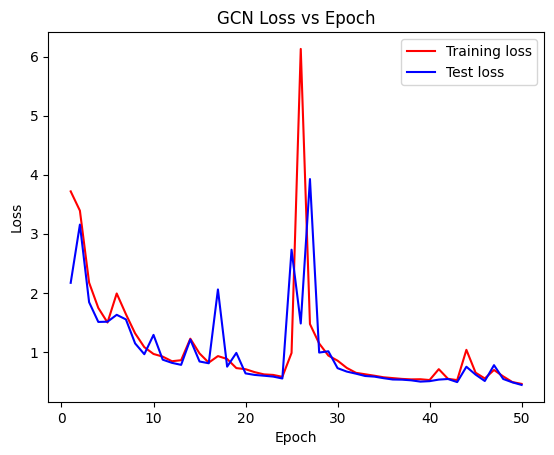

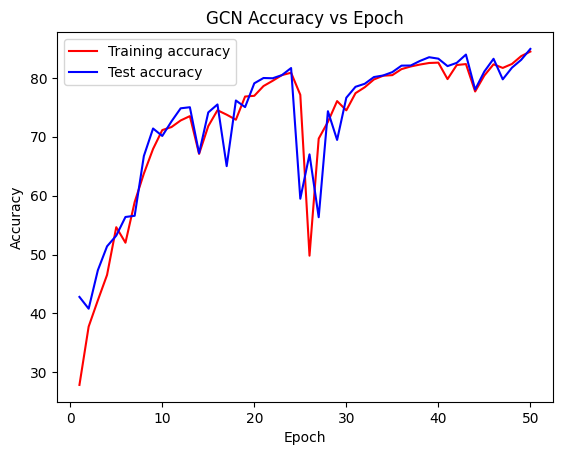

In [8]:
# Plot accuracy and loss vs epoch
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='Test loss')
plt.title('GCN Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
plt.title('GCN Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()